<img width="10%" alt="Naas" src="https://landen.imgix.net/jtci2pxwjczr/assets/5ice39g4.png?w=160"/>

# World Situation Dashboard 

**Tags:** #dashboard #plotly #dash #naas #asset #automation #ai #analytics

**Author:** [Jeremy Ravenel](https://www.linkedin.com/in/jeremyravenel/)

This notebook enables you to generate a dashboard to follow the world situation.

## Input

### Install packages

In [1]:
#!pip install dash   
#!pip install dash-html-components                                         
#!pip install dash-core-components                                     
#!pip install plotly

### Import library

In [42]:
import os
import naas_drivers
import naas
import dash
from dash import html, dcc, Input, Output, State
import dash_bootstrap_components as dbc
import plotly.graph_objects as go
import plotly.express as px
from dash_bootstrap_components._components.Container import Container
import pandas as pd
from plotly.subplots import make_subplots


### Defining the port of the dashboard

In [19]:
DASH_PORT = 8050

### Input data from Gsheets

In [4]:
spreadsheet_id = "1yi0qzuUEnE9wMWWQFIVq5Uou8ChxFqF0MMqFM5FtVIM"

## Model

### Data

#### Highlighted KPIs

In [5]:
# Dataframe is returned
df_hkpis = naas_drivers.gsheet.connect(spreadsheet_id).get(
    sheet_name="KPIS"
)

#### Earth Overshoot Day

In [6]:
def overshootday():

    return fig  


#### Land and Ocean Temperature

In [7]:
def landoceantemp():

    return fig  


#### Energy consumption by source

In [8]:
def energyconsumption():

    return fig  


#### Threaten species

In [9]:
def threatenspecies():

    return fig  


#### Per Capita emissions

In [10]:
def percapitaemissions():

    return fig  


#### Estimated annual world water use

In [11]:
def annualwateruse():

    return fig  


#### Barline 

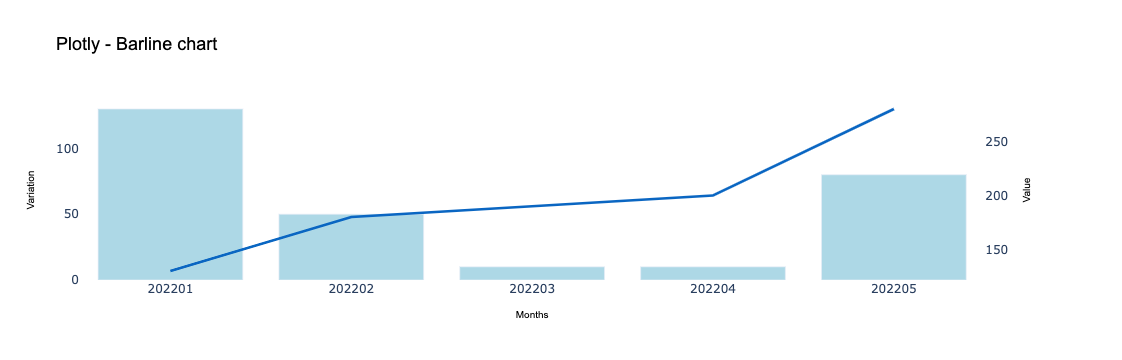

In [109]:
data = [
    {"DATE": "202201", "VALUE": 130, "VARV": 130},
    {"DATE": "202202", "VALUE": 180, "VARV": 50},
    {"DATE": "202203", "VALUE": 190, "VARV": 10},
    {"DATE": "202204", "VALUE": 200, "VARV": 10},
    {"DATE": "202205", "VALUE": 280, "VARV": 80},
]
df = pd.DataFrame(data)
df

def create_barlinechart(df,
                        label="DATE",
                        value="VALUE",
                        varv="VARV",
                        xaxis_title="Months",
                        yaxis_title_r=None,
                        yaxis_title_l=None):    
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(
        go.Bar(
            x=df[label],
            y=df[varv],
            marker=dict(color="#ADD8E6"),
        ),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(
            x=df[label],
            y=df[value],
            mode="lines",
            line=dict(color="#0A66C2", width=2.5),
        ),
        secondary_y=True,
    )

    # Add figure title
    fig.update_layout(
        title="Plotly - Barline chart",
        title_font=dict(family="Arial", size=18, color="black"),
        legend=None,
        plot_bgcolor="#ffffff",
        #width=1200,
        #height=800,
        paper_bgcolor="white",
        xaxis_title=xaxis_title,
        xaxis_title_font=dict(family="Arial", size=10, color="black"),
    )

    # Set y-axes titles
    fig.update_yaxes(
        title_text=yaxis_title_r,
        title_font=dict(family="Arial", size=10, color="black"),
        secondary_y=False
    )
    fig.update_yaxes(
        title_text=yaxis_title_l,
        title_font=dict(family="Arial", size=10, color="black"),
        secondary_y=True
    )
    fig.update_traces(showlegend=False)
    fig.show()
    return fig

fig = create_barlinechart(df,
                          yaxis_title_r="Variation",
                          yaxis_title_l="Value")

#### Create Heatmap

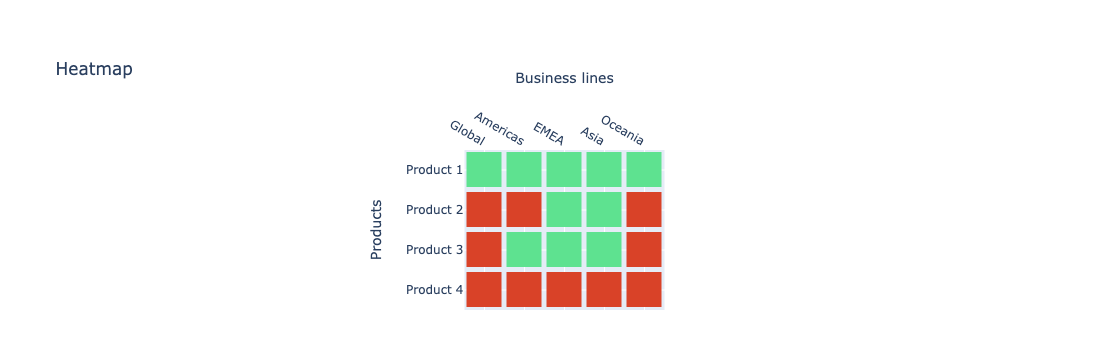

In [171]:
data = [[54.25, 65, 52, 51, 49],
        [20, 16, 60, 80, 30],
        [30, 60, 51, 59, 20],
        [40, 30, 12, 25, 20]]
df = pd.DataFrame(data)
df

title = "Heatmap"
config = {'displayModeBar': False}

def update_layout(fig, title=None, plot_bgcolor=None, showlegend=None, margin=None):
    fig.update_layout(
        title=title,
        plot_bgcolor=plot_bgcolor,
        #width=1200,
        margin=margin,
       #height=800,
        showlegend=showlegend)
    return fig

def heatmap(df,
            x,
            y,
            x_label,
            y_label,
            color,
            colorscale=[[0, "#d94228"],[0.5, "#d94228"],[0.5, "#5ee290"],[1.0, "#5ee290"]],
            title=None,
            margin=None):
    fig = go.Figure()
    fig = px.imshow(df,
                    labels=dict(x=x_label, y=y_label, color=color),
                    x=x,
                    y=y)
    fig.update_xaxes(side="top")
    fig.update_traces(xgap=5, selector=dict(type='heatmap'))
    fig.update_traces(ygap=5, selector=dict(type='heatmap'))
    fig.update_traces(dict(showscale=False, 
                           coloraxis=None, 
                           colorscale=colorscale),
                           selector={'type':'heatmap'})
    fig = update_layout(fig, title=title, margin=margin)
    fig.show(config=config)
    return fig

heatmap = heatmap(df,
              x=['Global', 'Americas', 'EMEA', 'Asia', 'Oceania'],
              y=['Product 1', 'Product 2', 'Product 3', 'Product 4'],
              x_label="Business lines",
              y_label="Products",
              color="Sales",
              title=title,
              margin=dict(l=0, r=0, t=150, b=50))   

### Design

#### Initialize Dash app

In [172]:
app = dash.Dash(requests_pathname_prefix=f'/user/{os.environ.get("JUPYTERHUB_USER")}/proxy/{DASH_PORT}/', 
                external_stylesheets=[dbc.themes.BOOTSTRAP])   
#app = dash.Dash() if you are not in Naas

#### Search Bar

In [83]:
search_bar = dbc.Row(
    [
        dbc.Col(dbc.Input(type="search", placeholder="Explore")),
        dbc.Col(
            dbc.Button(
                "Search", color="primary", className="ms-2", n_clicks=0
            ),
            width="auto",
        ),
    ],
    className="g-0 ms-auto flex-nowrap mt-3 mt-md-0",
    align="center",
)

#### Card body

In [119]:
card_content = [
    dbc.CardHeader("Card header"),
    dbc.CardBody(
        [
            html.H5("Card title", className="card-title"),
            html.P(
                "This is some card content that we'll reuse",
                className="card-text",
            ),
        ]
    ),
]

#### Dropdown Menu

In [173]:
nav_dropdown = dbc.DropdownMenu(
                    children=[
                        dbc.DropdownMenuItem("By Country", header=True),
                        dbc.DropdownMenuItem("France", href="#"),
                        dbc.DropdownMenuItem("USA", href="#"),
                        dbc.DropdownMenuItem("By Topic", header=True),
                        dbc.DropdownMenuItem("Temperature anomaly", href="#"),
                        dbc.DropdownMenuItem("COVID 19", href="#"),
                    ],
                    label="Explore more",
                ),

In [177]:
app.title = 'World Situation Room'
app.layout = html.Div(
    [
        #Navbar
        dbc.Navbar(
            dbc.Container(
                [
                    html.A(
                        # Use row and col to control vertical alignment of logo / brand
                        dbc.Row(
                            [
                                dbc.Col(html.Img(src="https://pbs.twimg.com/profile_images/1243203211114274817/WqWaa9Bm_400x400.jpg", height="30px")),
                                dbc.Col(dbc.NavbarBrand("World Situation Room", className="ms-2")),
                            ],
                            align="center",
                            className="g-0",
                        ),
                        href="https://mobile.twitter.com/ws_room/photo",
                        style={"textDecoration": "none"},
                    ),
                    dbc.NavbarToggler(id="navbar-toggler", n_clicks=0),   
                    dbc.NavItem(dbc.NavLink("Twitter", href="https://mobile.twitter.com/ws_room",target="_blank"),style={"text-align": "left"}),
                    dbc.DropdownMenu(
                        children=[
                            dbc.DropdownMenuItem("By Country", header=True),
                            dbc.DropdownMenuItem("France", href="#"),
                            dbc.DropdownMenuItem("USA", href="#"),
                            dbc.DropdownMenuItem("By Topic", header=True),
                            dbc.DropdownMenuItem("Temperature anomaly", href="#"),
                            dbc.DropdownMenuItem("COVID 19", href="#"),
                        ],
                        nav=True,
                        in_navbar=True,
                        label="Explore more",)
                ]
            ),
            color="dark",
            dark=True,
        ), 
        
        #HKPIS
        dbc.Row(
            [
                dbc.Col(dbc.Card(
                    dbc.CardBody(
                        [
                            html.H5("🧬 Carbon Dioxyde", className="card-title"),
                            html.P(
                                "419 ppm",
                                className="card-text",
                            ),
                        ]
                    ),color="light", inverse=False)),
                dbc.Col(dbc.Card(
                    dbc.CardBody(
                        [
                            html.H5("🌡 Global Temperature", className="card-title"),
                            html.P(
                                "+0.85°C",
                                className="card-text",
                            ),
                        ]
                    ),color="light", inverse=False)),
                dbc.Col(dbc.Card(
                    dbc.CardBody(
                        [
                            html.H5("❄️ Artic Sea Ice", className="card-title"),
                            html.P(
                                "-13% per decade",
                                className="card-text",
                            ),
                        ]
                    ),color="light", inverse=False)),
                dbc.Col(dbc.Card(
                    dbc.CardBody(
                        [
                            html.H5("🧊 Ice Sheet", className="card-title"),
                            html.P(
                                "-152 bilions metric",
                                className="card-text",
                            ),
                        ]
                    ),color="light", inverse=False)),
                dbc.Col(dbc.Card(
                    dbc.CardBody(
                        [
                            html.H5("🌊 Sea Level", className="card-title"),
                            html.P(
                                "+1O1 mm",
                                className="card-text",
                            ),
                        ]
                    ),color="light", inverse=False)),
                dbc.Col(dbc.Card(
                    dbc.CardBody(
                        [
                            html.H5("🔥 Ocean Heat", className="card-title"),
                            html.P(
                                "+337 zettajoules",
                                className="card-text",
                            ),
                        ]
                    ),color="light", inverse=False)),
            ],
            className="mb-4",
        ),
        
        
        #Charts     
        dbc.Row(
            [
                dbc.Col([
                    dcc.Graph(id="test2",figure=fig)]),
                dbc.Col([
                    dcc.Graph(id="test3",figure=heatmap)]),
            ]
        ),
        dbc.Row(
            [
                dbc.Col([
                    dcc.Graph(id="test4",figure=fig)]),
                dbc.Col([
                    dcc.Graph(id="test5",figure=fig)]),
            ]
        ),
    ],

)

# add callback for toggling the collapse on small screens
@app.callback(
    Output("navbar-collapse", "is_open"),
    [Input("navbar-toggler", "n_clicks")],
    [State("navbar-collapse", "is_open")],
)
def toggle_navbar_collapse(n, is_open):
    if n:
        return not is_open
    return is_open

## Output

### Generate URL and show logs

In [ ]:
if __name__ == '__main__':
    app.run_server(proxy=f"http://127.0.0.1:{DASH_PORT}::https://app.naas.ai")

Dash is running on https://app.naas.ai/user/jeremy@naas.ai/proxy/8050/

Dash is running on https://app.naas.ai/user/jeremy@naas.ai/proxy/8050/

Dash is running on https://app.naas.ai/user/jeremy@naas.ai/proxy/8050/

Dash is running on https://app.naas.ai/user/jeremy@naas.ai/proxy/8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050 (Press CTRL+C to quit)
127.0.0.1 - - [08/Aug/2022 23:39:52] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [08/Aug/2022 23:39:53] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [08/Aug/2022 23:39:53] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [08/Aug/2022 23:39:53] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 200 -
127.0.0.1 - - [08/Aug/2022 23:39:53] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 200 -
127.0.0.1 - - [09/Aug/2022 12:24:43] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [09/Aug/2022 12:24:43] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [09/Aug/2022 12:24:43] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [09/Aug/2022 12:24:43] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 200 -
127.0.0.1 - - [09/Aug/2022 12:24:43] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 200 -
127.0.0.1 - - [09/Aug/2022 12:24:44] "GET /_favicon.ico?v=2.6.0 HTTP/1.1" 200 -
127.0.0.1 -